In [1]:
#pip install pandas_datareader
#pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as web
from matplotlib import pyplot as plt
%matplotlib inline
import yfinance as yfin
yfin.pdr_override()
#import pypfopt
#plt.style.use('fivethirtyeight') 

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
#defining time range
from datetime import datetime, timedelta
start =  datetime.today() - timedelta(days=365) #Last 365 days
end = datetime.today()
#print(start, end)

symbols = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLRE", "XLU", "SPY", "BIL"]
stock_data = web.get_data_yahoo(symbols, start= start, end= end)

In [4]:
#print(stock_data)

pct_returns_df = stock_data["Adj Close"].pct_change().apply(lambda x: np.log(1+x))
pct_returns_df.dropna(inplace= True)
#print(pct_returns_df)

excess_returns_df = pct_returns_df.sub(pct_returns_df['BIL'], axis= 0)
print(excess_returns_df)

Symbols          XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU       SPY  BIL
Date                                                                                                                                   
2021-08-11  0.001930  0.002916  0.003341  0.007821  0.011405 -0.009964  0.012875  0.013968  0.000130  0.005418  0.009290  0.002482  0.0
2021-08-12  0.001806  0.000440 -0.000556 -0.000999  0.001803  0.007859 -0.001897 -0.001620  0.005725  0.003452  0.001027  0.002992  0.0
2021-08-13  0.000492 -0.002969  0.008200 -0.011977 -0.007598  0.006118 -0.003247  0.000817  0.005325  0.006545  0.006904  0.001709  0.0
2021-08-16  0.001900 -0.004419  0.005994 -0.018366 -0.002377  0.011524  0.003641 -0.004768  0.004725  0.001288  0.006316  0.002571  0.0
2021-08-17 -0.008315 -0.024025  0.000548 -0.010361 -0.007041  0.011764 -0.010879 -0.011576 -0.008320  0.001922  0.000579 -0.006577  0.0
...              ...       ...       ...       .

         Standard Deviation  Mean Excess Return
Symbols                                        
XLC                0.016458           -0.001471
XLY                0.019355           -0.000422
XLP                0.009934            0.000244
XLE                0.020905            0.001803
XLF                0.013983           -0.000434
XLV                0.010626           -0.000002
XLI                0.011901           -0.000285
XLB                0.013132           -0.000327
XLK                0.017757           -0.000214
XLRE               0.013280           -0.000040
XLU                0.010943            0.000541
SPY                0.012939           -0.000243
BIL                0.000000            0.000000


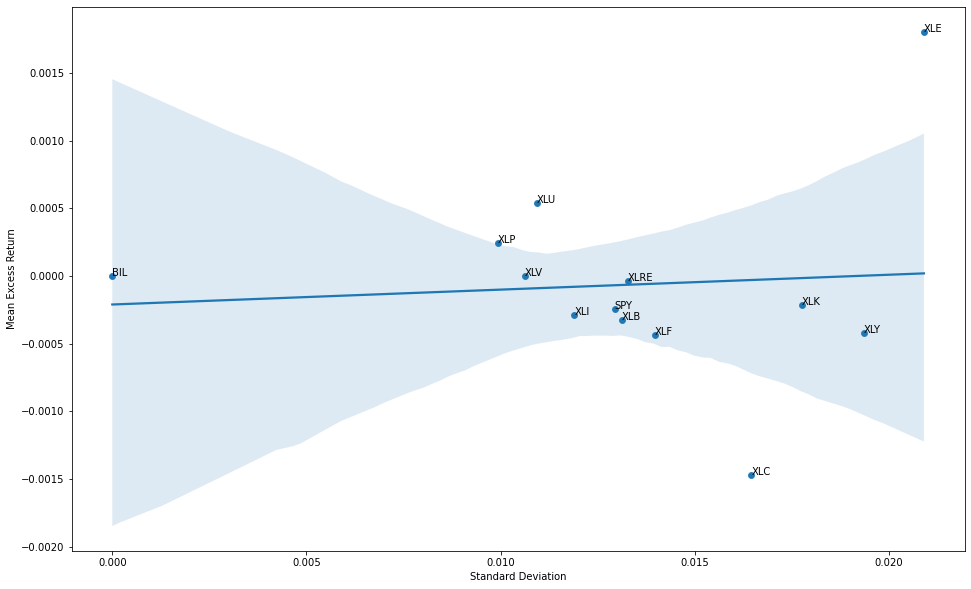

In [5]:
import seaborn as sns

excess_std_mean_df = pd.DataFrame(columns = ['Standard Deviation', 'Mean Excess Return'])
excess_std_mean_df['Standard Deviation'] = excess_returns_df.std()
excess_std_mean_df['Mean Excess Return'] = excess_returns_df.mean()
print(excess_std_mean_df)

excess_std_mean_df.plot(kind = 'scatter', x = 'Standard Deviation', y = 'Mean Excess Return')
for i, symbol in enumerate(symbols):
    plt.annotate(symbol, (excess_std_mean_df['Standard Deviation'][i], excess_std_mean_df['Mean Excess Return'][i]))

#a, b = np.polyfit(excess_std_mean_df['Standard Deviation'], excess_std_mean_df['Mean Excess Return'], 1)
#plt.plot(excess_std_mean_df['Standard Deviation'], a*excess_std_mean_df['Standard Deviation']+b, linestyle = '--', linewidth = 2)

sns.regplot(x= excess_std_mean_df['Standard Deviation'], y= excess_std_mean_df['Mean Excess Return']) #ci= 0
plt.show()

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU       SPY  BIL
Symbols                                                                                                                             
XLC      1.000000  0.813211  0.417864  0.251515  0.678032  0.583117  0.716437  0.685392  0.843695  0.555358  0.278755  0.868127  NaN
XLY      0.813211  1.000000  0.456462  0.269930  0.701208  0.551596  0.755251  0.687301  0.883165  0.580714  0.260380  0.899449  NaN
XLP      0.417864  0.456462  1.000000  0.201228  0.566779  0.689834  0.635408  0.595435  0.499363  0.650294  0.659141  0.628047  NaN
XLE      0.251515  0.269930  0.201228  1.000000  0.469461  0.219270  0.477617  0.494756  0.255884  0.284606  0.255106  0.390401  NaN
XLF      0.678032  0.701208  0.566779  0.469461  1.000000  0.634437  0.853251  0.827560  0.707706  0.611451  0.383284  0.836481  NaN
XLV      0.583117  0.551596  0.689834  0.219270  0.634437  1.000000  

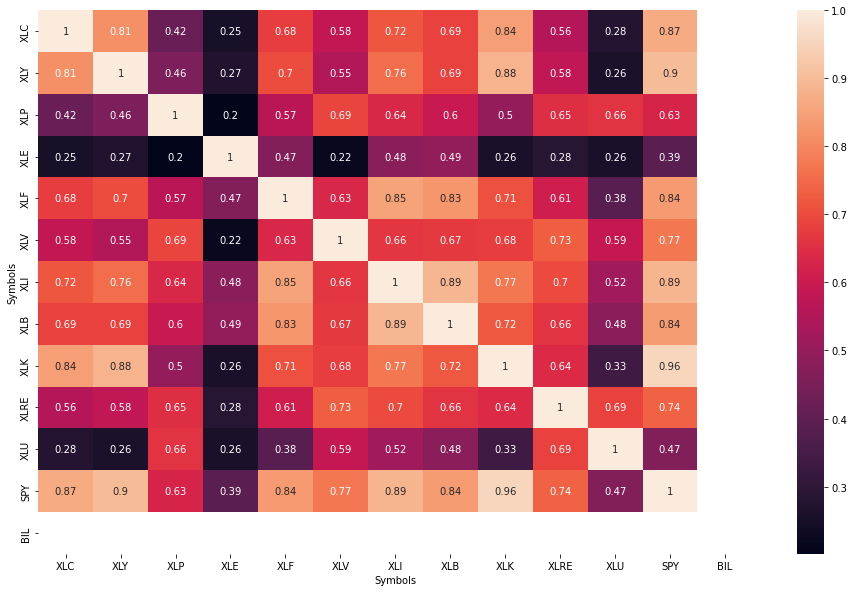

<Figure size 1152x720 with 0 Axes>

In [6]:
corr_matrix_excess = excess_returns_df.corr()
print(corr_matrix_excess)
sns.heatmap(corr_matrix_excess, annot= True)
plt.show()
plt.clf()

In [20]:
from sklearn.linear_model import LinearRegression

excess_returns_df = excess_returns_df.dropna()
betas_df = pd.DataFrame(columns= symbols)
#print(betas_df)
alphas_df = pd.DataFrame(columns= symbols)
#print(expected_returns_df)
alphas_list = []

for column in excess_returns_df:   
    x = np.array(excess_returns_df[column]).reshape((-1, 1))
    #print(x)

    y = np.array(excess_returns_df['SPY'])
    #print(y)
    
    model = LinearRegression().fit(x, y)
    alphas_df[column] = pd.Series(model.intercept_)
    betas_df[column] = model.coef_
    #print(column, model.intercept_, model.coef_)
    alphas_list.append(model.intercept_)

alphas_list = alphas_list[:-2]
#print(alphas_list)
print(alphas_df)
print()
print(betas_df)

        XLC      XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU           SPY       BIL
0  0.000761  0.00001 -0.000443 -0.000679  0.000092 -0.000241  0.000032  0.000027 -0.000094 -0.000215 -0.000541 -1.626303e-19 -0.000243

        XLC       XLY       XLP       XLE      XLF       XLV       XLI       XLB       XLK     XLRE       XLU  SPY  BIL
0  0.682498  0.601283  0.818055  0.241631  0.77403  0.940512  0.963832  0.826388  0.696201  0.71809  0.550605  1.0  0.0


In [21]:
hedge_df = excess_returns_df.reset_index()
hedge_df = hedge_df.iloc[:,1:]
#print(hedge_df)

for col in hedge_df:
    for i, row_value in hedge_df[col].iteritems():
        hedge_df[col][i] = hedge_df[col][i] - betas_df[col]*hedge_df["SPY"][i]

hedge_df.drop(index = hedge_df.index[0], axis= 0, inplace= True)
hedge_df.drop(["SPY", "BIL"], axis= 1, inplace= True)
print(hedge_df)

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU
1       -0.000237 -0.001360 -0.003004 -0.001722 -0.000514  0.005044 -0.004781 -0.004093  0.003642  0.001303 -0.000621
2       -0.000674 -0.003997  0.006802 -0.012390 -0.008921  0.004511 -0.004894 -0.000596  0.004135  0.005318  0.005963
3        0.000146 -0.005964  0.003891 -0.018988 -0.004367  0.009106  0.001164 -0.006892  0.002935 -0.000558  0.004900
4       -0.003826 -0.020070  0.005928 -0.008772 -0.001951  0.017950 -0.004540 -0.006141 -0.003742  0.006644  0.004200
5       -0.000141  0.010182 -0.003546 -0.018390 -0.003858 -0.004970 -0.000391 -0.002617 -0.006229 -0.002605  0.000985
..            ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
246      0.013167  0.014775 -0.006163 -0.032805  0.003009 -0.005485 -0.005621 -0.011779  0.015462 -0.006984 -0.002299
247      0.004726  0.004395 -0.006148 -0.037795 -0.00280

Symbols       XLC       XLY       XLP       XLE           XLF       XLV       XLI       XLB       XLK          XLRE       XLU
Symbols                                                                                                                      
XLC      0.000097  0.000063 -0.000045 -0.000003 -1.971888e-06 -0.000037 -0.000021 -0.000008  0.000048 -1.583739e-05 -0.000034
XLY      0.000063  0.000165 -0.000063  0.000016  2.284995e-06 -0.000068 -0.000028 -0.000014  0.000085 -1.643804e-05 -0.000053
XLP     -0.000045 -0.000063  0.000079 -0.000031 -1.592577e-06  0.000039  0.000018  0.000008 -0.000053  2.264610e-05  0.000049
XLE     -0.000003  0.000016 -0.000031  0.000397  5.022777e-05 -0.000038  0.000023  0.000047 -0.000003  1.561474e-06  0.000006
XLF     -0.000002  0.000002 -0.000002  0.000050  6.140650e-05 -0.000008  0.000015  0.000023 -0.000009 -2.401023e-07 -0.000005
XLV     -0.000037 -0.000068  0.000039 -0.000038 -7.938049e-06  0.000061  0.000005  0.000002 -0.000043  2.113987e-05  0

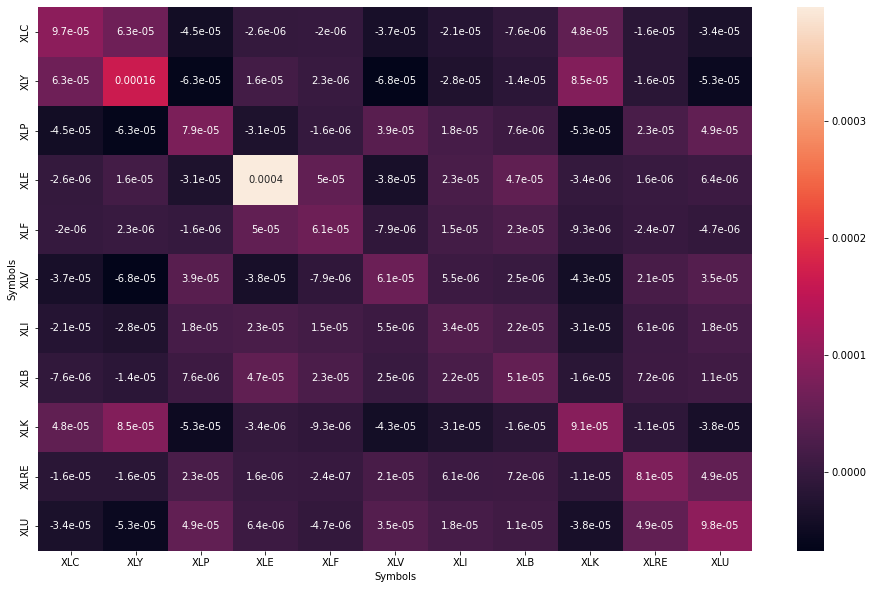

In [22]:
hedge_var_covar = hedge_df.cov()
#print("Variance - covariance matrix")
print(hedge_var_covar)
sns.heatmap(hedge_var_covar, annot= True)
print()
print("E[R]-rf")
print(pd.Series(alphas_list, index= symbols[:-2]))

{'XLC': 0.5, 'XLY': -0.02933, 'XLP': -0.15271, 'XLE': -0.11469, 'XLF': 0.15818, 'XLV': 0.23435, 'XLI': 0.5, 'XLB': 0.09715, 'XLK': -0.07133, 'XLRE': 0.12327, 'XLU': -0.2449}
Expected annual return: 0.1%
Annual volatility: 0.6%
Sharpe Ratio: 0.11


<AxesSubplot:xlabel='Weight'>

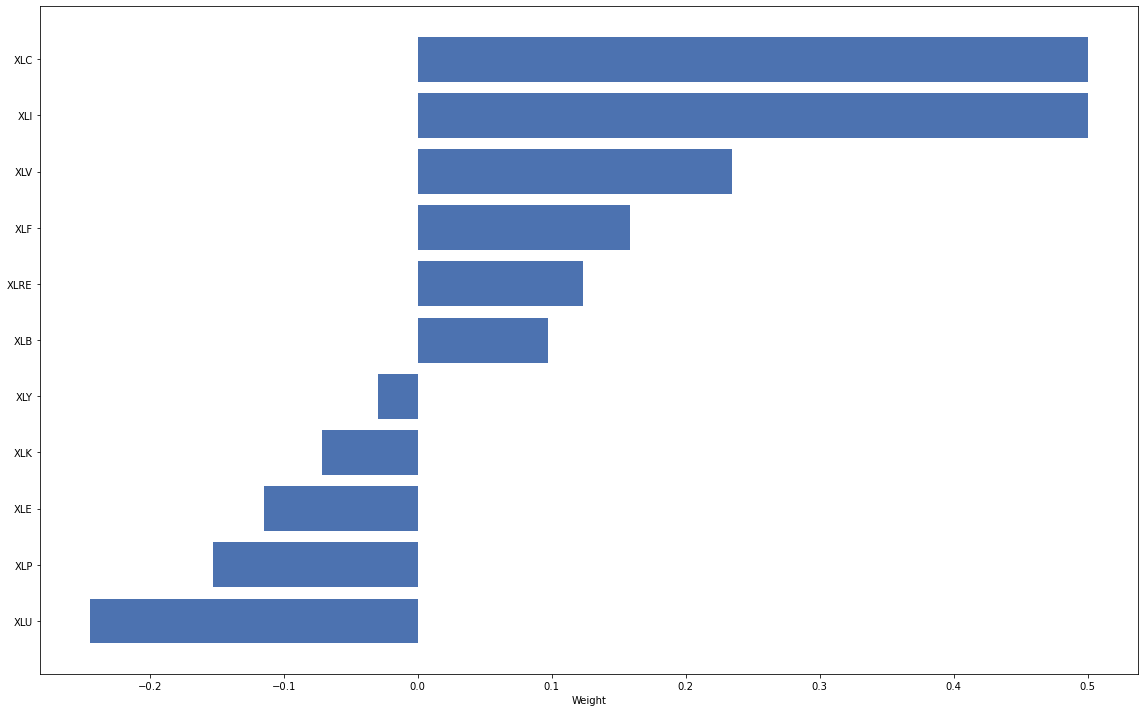

In [23]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

#excess_returns = excess_std_mean_df["Mean Excess Return"].drop(["SPY", "BIL"])
#print(excess_returns)

ef = EfficientFrontier(alphas_list, hedge_var_covar, weight_bounds= (-0.25, 0.5)) # 
weights = ef.max_sharpe(risk_free_rate= 0)
cleaned_weights = dict(ef.clean_weights())

print(cleaned_weights)
ef.portfolio_performance(verbose = True, risk_free_rate= 0)

plotting.plot_weights(cleaned_weights)

In [24]:
final_df = pd.DataFrame.from_dict(cleaned_weights, orient= 'index')
final_df.rename(columns= {0: "Weights"}, inplace= True)

betas_df.drop(["SPY", "BIL"], axis= 1, inplace= True)
#print(betas_df.values)
final_df["Beta"] = betas_df.values.T
final_df["Market"] = final_df["Weights"]*final_df["Beta"]*-1
final_df["BIL"] = final_df["Weights"]*(final_df["Beta"]-1)

print(final_df)

sum_market = final_df["Market"].sum()
sum_bil = final_df["BIL"].sum()
print()
print(sum_market, sum_bil)
print(sum_market+sum_bil)



      Weights      Beta    Market       BIL
XLC   0.50000  0.682498 -0.341249 -0.158751
XLY  -0.02933  0.601283  0.017636  0.011694
XLP  -0.15271  0.818055  0.124925  0.027785
XLE  -0.11469  0.241631  0.027713  0.086977
XLF   0.15818  0.774030 -0.122436 -0.035744
XLV   0.23435  0.940512 -0.220409 -0.013941
XLI   0.50000  0.963832 -0.481916 -0.018084
XLB   0.09715  0.826388 -0.080284 -0.016866
XLK  -0.07133  0.696201  0.049660  0.021670
XLRE  0.12327  0.718090 -0.088519 -0.034751
XLU  -0.24490  0.550605  0.134843  0.110057

-0.9800360564281614 -0.019953943571838495
-0.9999899999999999


       Weights     $ Amount  Last Price  Number of Shares
SPY  -0.980036 -9800.360564  411.350006             -24.0
XLU  -0.244900 -2449.000000   75.169998             -33.0
XLP  -0.152710 -1527.100000   74.489998             -21.0
XLE  -0.114690 -1146.900000   74.750000             -15.0
XLK  -0.071330  -713.300000  144.309998              -5.0
XLY  -0.029330  -293.300000  162.419998              -2.0
BIL  -0.019954  -199.539436   91.419998              -2.0
XLB   0.097150   971.500000   77.160004              13.0
XLRE  0.123270  1232.700000   44.389999              28.0
XLF   0.158180  1581.800000   33.840000              47.0
XLV   0.234350  2343.500000  131.360001              18.0
XLC   0.500000  5000.000000   56.860001              88.0
XLI   0.500000  5000.000000   95.739998              52.0


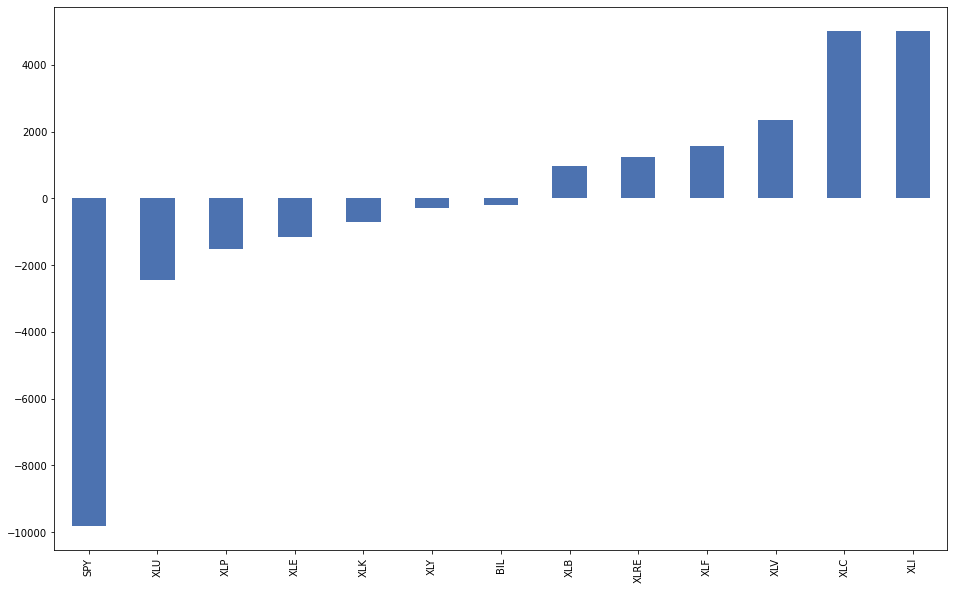

In [25]:
from pypfopt.discrete_allocation import get_latest_prices

cash_investment = 10000

cleaned_weights["SPY"] = sum_market
cleaned_weights["BIL"] = sum_bil

discrete_df = pd.DataFrame.from_dict(cleaned_weights, orient= 'index')
discrete_df.rename(columns= {0: "Weights"}, inplace= True)
discrete_df["$ Amount"] = discrete_df["Weights"]*cash_investment
discrete_df["Last Price"] = get_latest_prices(stock_data["Adj Close"])
discrete_df["Number of Shares"] = round(discrete_df["$ Amount"]/discrete_df["Last Price"], 0)

discrete_df.sort_values(by=["$ Amount"], inplace= True)
print(discrete_df)
discrete_df["$ Amount"].plot(kind = 'bar')
plt.show()